In [1]:
import os
import pandas as pd

modality = {'01': 'full-AV', '02': 'video-only', '03': 'audio-only'}
vocal_channel = {'01': 'speech', '02': 'song'}
emotion = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
intensity = {'01': 'normal', '02': 'strong'}
statement = {'01': 'Kids are talking by the door', '02': 'Dogs are sitting by the door'}
repetition = {'01': '1st repetition', '02': '2nd repetition'}

data = []

base_path = "../Dataset"  

for root, dirs, files in os.walk(base_path):
    for filename in files:
        if not filename.lower().endswith('.wav'):
            continue
        
        parts = filename.split('.')[0].split('-')
        if len(parts) != 7:
            continue
        
        file_info = {
            'Filename': filename,
            'Modality': modality.get(parts[0]),
            'Vocal Channel': vocal_channel.get(parts[1]),
            'Emotion': emotion.get(parts[2]),
            'Intensity': intensity.get(parts[3]),
            'Statement': statement.get(parts[4]),
            'Repetition': repetition.get(parts[5]),
            'Actor': int(parts[6]),
            'Gender': 'male' if int(parts[6]) % 2 == 1 else 'female',
            'Path': root  # path lengkap ke folder tempat file berada
        }
        data.append(file_info)

df = pd.DataFrame(data)
df.head()

,Filename,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor,Gender,Path
0,03-02-01-01-01-01-01.wav,audio-only,song,neutral,normal,Kids are talking by the door,1st repetition,1,male,../Dataset\Audio_Song_Actors\Actor_01
1,03-02-01-01-01-02-01.wav,audio-only,song,neutral,normal,Kids are talking by the door,2nd repetition,1,male,../Dataset\Audio_Song_Actors\Actor_01
2,03-02-01-01-02-01-01.wav,audio-only,song,neutral,normal,Dogs are sitting by the door,1st repetition,1,male,../Dataset\Audio_Song_Actors\Actor_01
3,03-02-01-01-02-02-01.wav,audio-only,song,neutral,normal,Dogs are sitting by the door,2nd repetition,1,male,../Dataset\Audio_Song_Actors\Actor_01
4,03-02-02-01-01-01-01.wav,audio-only,song,calm,normal,Kids are talking by the door,1st repetition,1,male,../Dataset\Audio_Song_Actors\Actor_01


In [2]:
df['Path'].head()

0    ../Dataset\Audio_Song_Actors\Actor_01
1    ../Dataset\Audio_Song_Actors\Actor_01
2    ../Dataset\Audio_Song_Actors\Actor_01
3    ../Dataset\Audio_Song_Actors\Actor_01
4    ../Dataset\Audio_Song_Actors\Actor_01
Name: Path, dtype: object

# EDA

In [3]:
df.isnull().sum()

Filename         0
Modality         0
Vocal Channel    0
Emotion          0
Intensity        0
Statement        0
Repetition       0
Actor            0
Gender           0
Path             0
dtype: int64

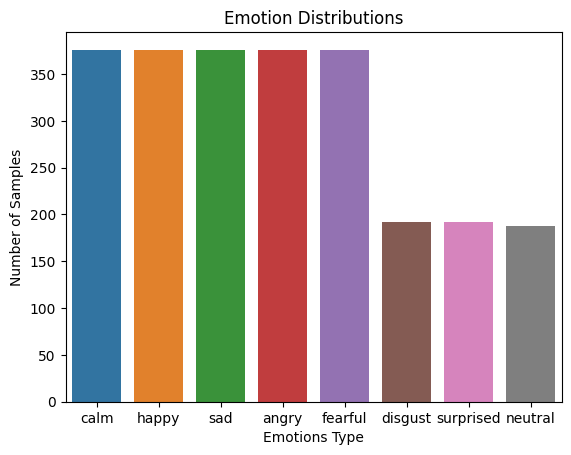

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.Figure(figsize=(10,5))
sns.countplot(x='Emotion', data=df, order=df['Emotion'].value_counts().index)
plt.title('Emotion Distributions')
plt.xlabel('Emotions Type')
plt.ylabel('Number of Samples')
plt.show()

In [5]:
emotions_count = df['Emotion'].value_counts(normalize=True) * 100

print(emotions_count.round(2))

Emotion
calm         15.33
happy        15.33
sad          15.33
angry        15.33
fearful      15.33
disgust       7.83
surprised     7.83
neutral       7.67
Name: proportion, dtype: float64


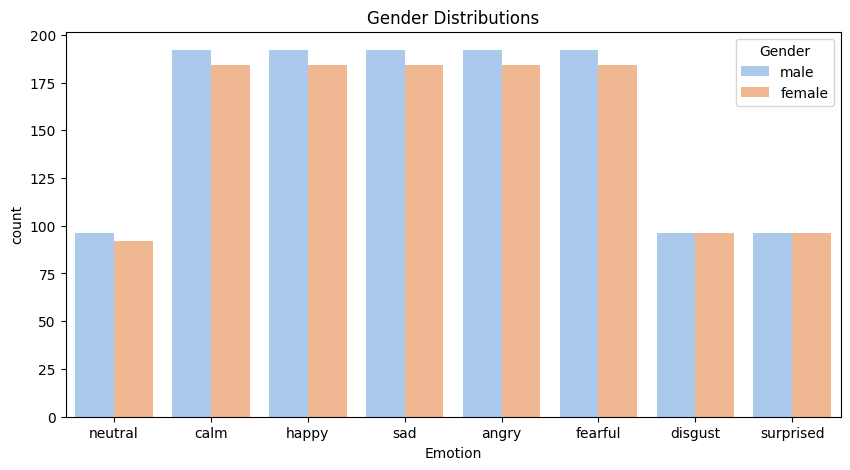

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(x='Emotion', hue='Gender' ,data=df, palette='pastel')
plt.title('Gender Distributions')
plt.show()

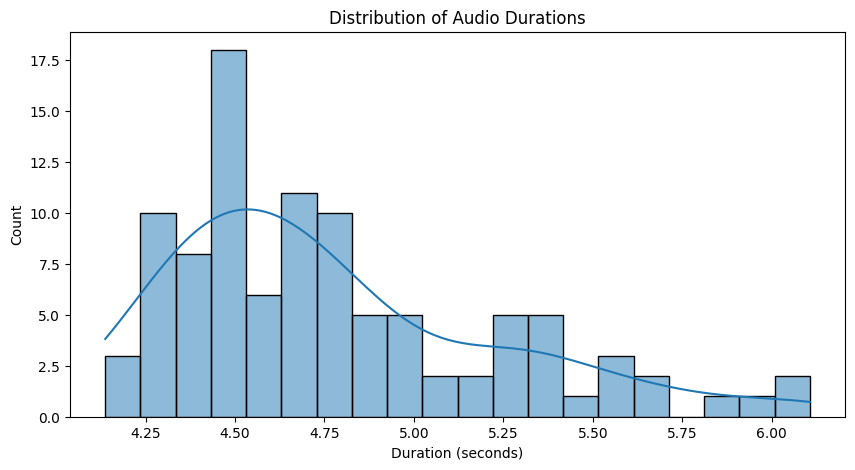

In [7]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

durations = []
df['Actor'] = df['Actor'].astype(int)

for _, row in df.iloc[:100].iterrows():
  actor_num = int(row['Actor'])
  filename = row['Filename']

  found_file = False
  for parent_folder in ["Audio_Speech_Actors", "Audio_Song_Actors"]:
    file_path = os.path.join(base_path, parent_folder, f"Actor_{actor_num:02d}", filename)

    if os.path.isfile(file_path):
      try:
        y, sr = librosa.load(file_path, sr=None)
        dur = librosa.get_duration(y=y, sr=sr)
        durations.append(dur)
        found_file = True
        break
      except Exception as e:
        print('error loading', file_path, "-", str(e))
        found_file=True
        break
  if not found_file:
    print('file is not in both folder, skip:', filename)

plt.figure(figsize=(10,5))
sns.histplot(durations, bins=20, kde=True)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()


In [8]:
df.columns

Index(['Filename', 'Modality', 'Vocal Channel', 'Emotion', 'Intensity',
       'Statement', 'Repetition', 'Actor', 'Gender', 'Path'],
      dtype='object')

# Preprocessing

In [9]:
import seaborn as sns
import librosa, librosa.display
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
df['Actor'] = df['Actor'].astype(int)
df['path'] = df.apply(lambda r: os.path.join(base_path, f"Actor_{int(r['Actor']):02d}", r['Filename']), axis=1)

print("Total Files: ", len(df))
print(df['Emotion'].value_counts())
print(df[['Actor', 'Gender']].value_counts())

Total Files:  2452
Emotion
calm         376
happy        376
sad          376
angry        376
fearful      376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64
Actor  Gender
1      male      104
2      female    104
23     male      104
22     female    104
21     male      104
20     female    104
19     male      104
17     male      104
16     female    104
15     male      104
14     female    104
13     male      104
12     female    104
11     male      104
10     female    104
9      male      104
8      female    104
7      male      104
6      female    104
5      male      104
4      female    104
3      male      104
24     female    104
18     female     60
Name: count, dtype: int64


In [11]:
def make_full_path(row):
  if row['Vocal Channel'] == 'speech':
    base = os.path.join("../Dataset/Audio_Speech_Actors", f"Actor_{int(row['Actor']):02d}")
  else:
    base = os.path.join("../Dataset/Audio_Song_Actors", f"Actor_{int(row['Actor']):02d}")
  return os.path.join(base, row['Filename'])

df['path'] = df.apply(make_full_path, axis=1)

In [12]:
SR = 16000
N_Mels = 128
Target_Width = 128

def load_audio(path, sr=SR):
  y,_ = librosa.load(path, sr=sr)
  y,_ = librosa.effects.trim(y)
  return y

def wav_to_mel(path, sr=SR, n_mels = N_Mels, target_width = Target_Width):
  try:
    y = load_audio(path, sr)
  except:
    return None
  
  S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
  S_db = librosa.power_to_db(S, ref=np.max)

  if S_db.shape[1] < target_width:
    pad_width = target_width - S_db.shape[1]
    S_db = np.pad(S_db, ((0,0), (0, pad_width)), mode='constant')
  else:
    S_db = S_db[:, :target_width]
  
  S_Norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-6)

  img = S_Norm.astype(np.float32)
  # make it into 3 channel to fix the VGG requirement
  img3 = np.stack([img, img, img], axis = -1)
  return img3

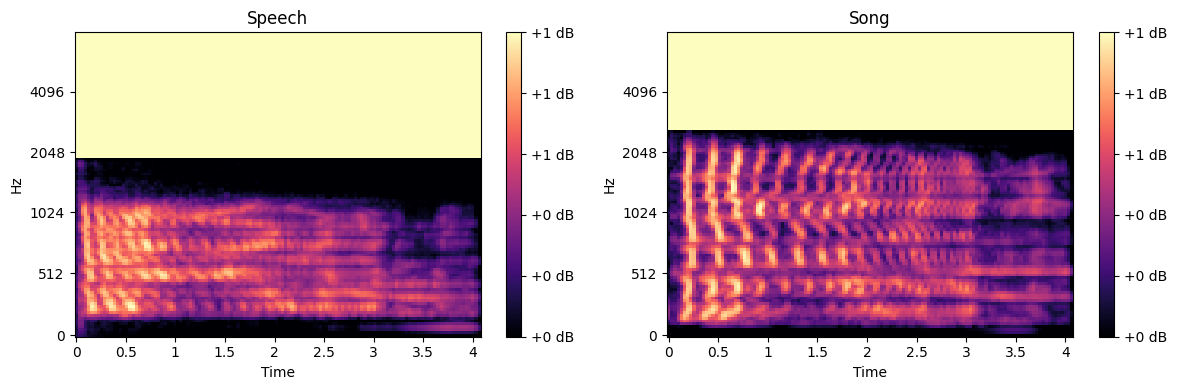

In [13]:
import librosa.display

speech_sample = df[df['Vocal Channel'] == 'speech'].iloc[0]
song_sample   = df[df['Vocal Channel'] == 'song'].iloc[0]

speech_img = wav_to_mel(speech_sample['path'])
song_img   = wav_to_mel(song_sample['path'])

if speech_img is None or song_img is None:
    print("Ada file yang gagal di-load")
else:
    plt.figure(figsize=(12,4))

    # Plot speech
    plt.subplot(1,2,1)
    librosa.display.specshow(speech_img[:,:,0].T, sr=SR, x_axis='time', y_axis='mel')
    plt.title('Speech')
    plt.colorbar(format='%+2.0f dB')

    # Plot song
    plt.subplot(1,2,2)
    librosa.display.specshow(song_img[:,:,0].T, sr=SR, x_axis='time', y_axis='mel')
    plt.title('Song')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()


In [14]:
labels = df['Emotion'].values
le = LabelEncoder()
y_all = le.fit_transform(labels)
num_classes = len(le.classes_)

x_list = []
y_list = []
for p, lab in zip(df['path'], y_all):
  img = wav_to_mel(p)
  if img is None:
    continue
  x_list.append(img)
  y_list.append(lab)

x = np.stack(x_list)
y = np.array(y_list)
print(x.shape, y.shape)

(2452, 128, 128, 3) (2452,)


# Training 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

print(x_train.shape, x_val.shape, x_test.shape)

(1764, 128, 128, 3) (197, 128, 128, 3) (491, 128, 128, 3)


In [16]:
def add_noise(y, noise_factor = 0.005):
  noise = np.random(len(y))
  return y + noise_factor * noise

def pitch_shift(y, sr, n_steps = 2):
  return librosa.effects.pitch_shift(y, sr, n_steps)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True
)

datagen.fit(x_train)

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Reshape, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_shape = (N_Mels, Target_Width, 3)
base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base.layers[:-12]:
  layer.trainable = False

x = base.output
# x = Reshape((-1, x.shape[-1]))(x)
# x = Attention()([x, x])
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation = 'softmax', dtype = 'float32')(x)

model = Model(inputs=base.input, outputs = out)
model.compile(
  optimizer = Adam(learning_rate=1e-5),
  loss = 'sparse_categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('vgg_head.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', patience=8, restore_best_weights=True)
ReduceLRON = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 4, min_lr = 1e-7)

history = model.fit(
  x_train, y_train,
  validation_data = (x_val, y_val),
  epochs = 30,
  batch_size = 4,
  callbacks = [checkpoint, early_stop, ReduceLRON]
)

Epoch 1/30
441/441 [==============================] - 29s 60ms/step - loss: 2.0703 - accuracy: 0.2540 - val_loss: 2.0347 - val_accuracy: 0.2437 - lr: 1.0000e-05
Epoch 2/30
441/441 [==============================] - 26s 59ms/step - loss: 1.7270 - accuracy: 0.3713 - val_loss: 1.7294 - val_accuracy: 0.3706 - lr: 1.0000e-05
Epoch 3/30
441/441 [==============================] - 26s 58ms/step - loss: 1.4844 - accuracy: 0.4592 - val_loss: 1.7221 - val_accuracy: 0.4670 - lr: 1.0000e-05
Epoch 4/30
441/441 [==============================] - 26s 59ms/step - loss: 1.3303 - accuracy: 0.5425 - val_loss: 1.2796 - val_accuracy: 0.5787 - lr: 1.0000e-05
Epoch 5/30
441/441 [==============================] - 26s 59ms/step - loss: 1.1614 - accuracy: 0.5947 - val_loss: 1.0755 - val_accuracy: 0.6244 - lr: 1.0000e-05
Epoch 6/30
441/441 [==============================] - 25s 58ms/step - loss: 0.9750 - accuracy: 0.6667 - val_loss: 1.4915 - val_accuracy: 0.5584 - lr: 1.0000e-05
Epoch 7/30
441/441 [==============

# Evalution

16/16 [==============================] - 5s 161ms/step - loss: 0.8500 - accuracy: 0.7475
test accuracy:  0.7474541664123535
16/16 [==============================] - 1s 87ms/step
              precision    recall  f1-score   support

       angry       0.78      0.88      0.82        75
        calm       0.74      0.85      0.80        75
     disgust       0.82      0.69      0.75        39
     fearful       0.70      0.76      0.73        75
       happy       0.84      0.61      0.71        75
     neutral       0.71      0.84      0.77        38
         sad       0.64      0.59      0.61        75
   surprised       0.86      0.79      0.83        39

    accuracy                           0.75       491
   macro avg       0.76      0.75      0.75       491
weighted avg       0.75      0.75      0.74       491



<Figure size 800x600 with 0 Axes>

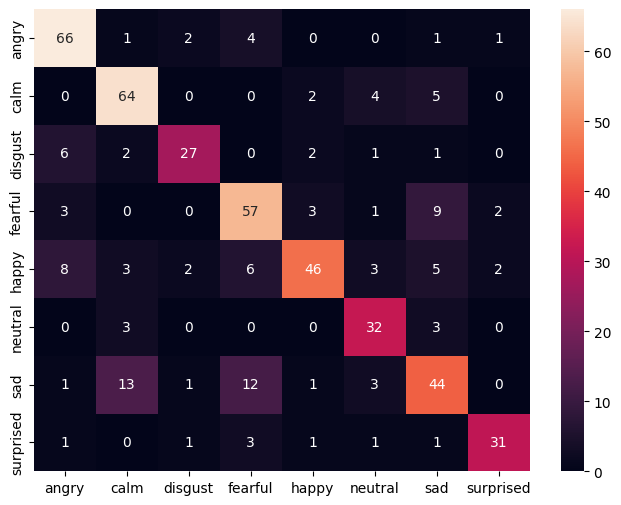

In [20]:
model.load_weights('vgg_head.h5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 1)
print("test accuracy: ", test_acc)

y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

Confusion_Matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6)); sns.heatmap(Confusion_Matrix, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

# Tuning

In [21]:
checkpoint = ModelCheckpoint('vgg_head.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', patience=6, restore_best_weights=True)
ReduceLRON = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-7)

In [22]:
from sklearn.utils.class_weight import compute_class_weight

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size=4).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size=8).prefetch(tf.data.AUTOTUNE)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)
class_weights = dict(enumerate(class_weights))

tf.keras.backend.clear_session()
model.fit(train_dataset,validation_data=val_dataset, epochs=30, callbacks = [checkpoint, early_stop, ReduceLRON], class_weight=class_weights)

Epoch 1/30
441/441 [==============================] - 30s 65ms/step - loss: 0.1313 - accuracy: 0.9734 - val_loss: 0.7907 - val_accuracy: 0.7462 - lr: 6.2500e-07
Epoch 2/30
441/441 [==============================] - 27s 61ms/step - loss: 0.1289 - accuracy: 0.9756 - val_loss: 0.7647 - val_accuracy: 0.7665 - lr: 6.2500e-07
Epoch 3/30
441/441 [==============================] - 26s 60ms/step - loss: 0.1054 - accuracy: 0.9813 - val_loss: 0.7889 - val_accuracy: 0.7513 - lr: 6.2500e-07
Epoch 4/30
441/441 [==============================] - 26s 59ms/step - loss: 0.1186 - accuracy: 0.9762 - val_loss: 0.7792 - val_accuracy: 0.7563 - lr: 6.2500e-07
Epoch 5/30
441/441 [==============================] - 26s 59ms/step - loss: 0.1301 - accuracy: 0.9632 - val_loss: 0.8266 - val_accuracy: 0.7513 - lr: 6.2500e-07
Epoch 6/30
441/441 [==============================] - 26s 59ms/step - loss: 0.1037 - accuracy: 0.9796 - val_loss: 0.7781 - val_accuracy: 0.7563 - lr: 3.1250e-07
Epoch 7/30
441/441 [==============

In [23]:
test_loss, test_acc = model.evaluate(x_test, y_test)

y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = y_test

emotion_labels = ['angry', 'calm', 'fearful', 'happy', 'neutral', 'sad', 'surprised', 'disgust']
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print(classification_report(y_true, y_pred_classes, target_names=emotion_labels))

16/16 [==============================] - 1s 87ms/step
Test Loss: 0.8361334800720215
Test Accuracy: 0.7698574066162109
              precision    recall  f1-score   support

       angry       0.85      0.88      0.86        75
        calm       0.77      0.81      0.79        75
     fearful       0.74      0.87      0.80        39
       happy       0.72      0.72      0.72        75
     neutral       0.85      0.67      0.75        75
         sad       0.73      0.87      0.80        38
   surprised       0.65      0.61      0.63        75
     disgust       0.89      0.87      0.88        39

    accuracy                           0.77       491
   macro avg       0.78      0.79      0.78       491
weighted avg       0.77      0.77      0.77       491



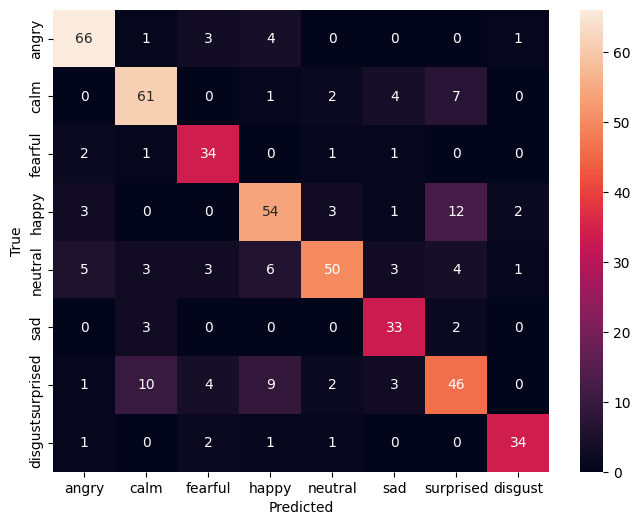

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [25]:
import numpy as np, collections
print("Support true:", np.bincount(y_true))
print("Support pred:", np.bincount(y_pred_classes))

Support true: [75 75 39 75 75 38 75 39]
Support pred: [78 79 46 75 59 45 71 38]
